In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys
import h5py
import json

sys.path.append(os.environ['ROOTDIR'])

from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

In [82]:
def get_cm_and_scores(path, name='model'):
    
    with open(os.path.join(path, 'conf.json')) as f:
        conf = json.load(f)
    
    df = pd.read_csv(os.path.join('..','..',conf['data'], 'objects.csv'))
    class_names = list(df['label'].values)

    with h5py.File(os.path.join(path, 'test', 'predictions.h5'), "r") as f:
        y_true = f['y_true'][()]
        y_pred = np.argmax(f['y_pred'][()][:, -1, :], 1)
    cm  = confusion_matrix(y_true, y_pred, normalize='true')
    
    with open(os.path.join(path, 'test', 'test_results.json'), 'r') as f:
        metrics = json.load(f)
    
    metrics['title'] = name
    return metrics, cm, class_names

In [84]:
metrics_0, cm_0, cls_names_0 = get_cm_and_scores( "../../runs/model_0/", name='RNN+Att.')
metrics_1, cm_1, cls_names_1 = get_cm_and_scores( "../../runs/model_1/", name='RNN')

<AxesSubplot:title={'center':'RNN + $\\Delta$ t + Mag + Mag std'}>

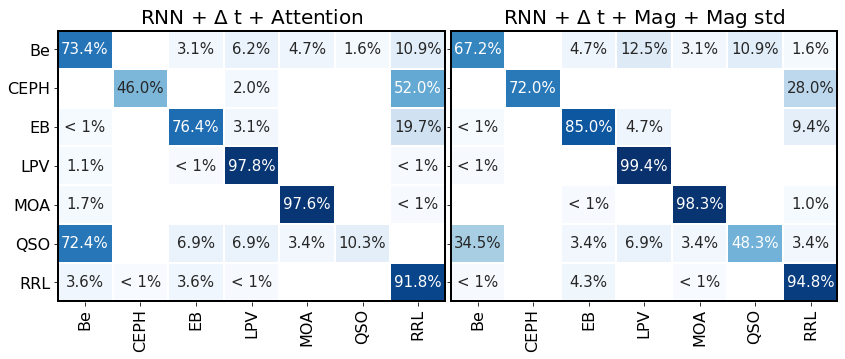

In [85]:
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.01})
plot_cm(cm_0, axes[0], title='RNN + $\Delta$ t + Attention', class_names=class_names)
plot_cm(cm_1, axes[1], title='RNN + $\Delta$ t + Mag + Mag std', class_names=class_names)

In [93]:
import pandas as pd

print('Model & F1 & Recall & Precision & Accuracy \\\\\hline')
for dictonary in [metrics_0, metrics_1]:
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\\hline '.format(dictonary['title'],
                                                          dictonary['f1'],
                                                          dictonary['recall'],
                                                          dictonary['precision'],
                                                          dictonary['accuracy']))

Model & F1 & Recall & Precision & Accuracy \\\hline
RNN+Att. & 0.72 & 0.70 & 0.84 & 0.87 \\\hline 
RNN & 0.83 & 0.81 & 0.87 & 0.91 \\\hline 
